<a href="https://colab.research.google.com/github/jhmuller/energy_price/blob/main/energy_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What
Cluster a collection of electricity price series into K clusters
so that within cluser distance is small.
Smaller K is better but smaller within cluster 
 distance is also better and these are at odds with each other.
Try different values for K until a reasonable balance between
within cluster distance and K is found.

# Why
This might be useful for an energy supplier in high level planning
for annual usage from it's customers.
There are no national energy suppliers, only regional.
However, at a national level it could be useful to see what
patterns emerge in the clusers.  This could be of use in 
making energy policy.


# Background
I was initially looking for some interesting time series data to do prediction with.   
I found this one of energy price for consumers broken down by state.  Clustering seemed like a better application for this data.  
You can find the data here https://www.eia.gov/electricity/data/state/  as well as some other energy data.

## Tools
Most internet searches for time series clustering I found,  pointed to the **tslearn** package.  

It uses Kmeans clustering, but it does have some different "metrics" it can use to measure 
distance between time series. 
Also, it seems to be modeled after scikit-learn so it should be easy to use.

So let's install tslearn.

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 875 kB 4.9 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tslearn

## Get the Data
I downloaded the monthly by state data, (note it is xlsx) then uploaded to my Google drive.

So here I will pull from my Google drive and plot the first few rows.

In [ ]:
from google.colab import drive
dd = "/content/drive/MyDrive/data"
try:
  os.listdir(dd)
except:
  drive.mount('/content/drive')
fpath = os.path.join(dd, "energy.xlsx")
orig = pd.read_excel(fpath)
orig.head(3)

Mounted at /content/drive


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,RESIDENTIAL,Unnamed: 5,Unnamed: 6,Unnamed: 7,COMMERCIAL,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,TRANSPORTATION,Unnamed: 17,Unnamed: 18,Unnamed: 19,TOTAL,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,NaN,NaN,NaN,NaN,Revenue,Sales,Customers,Price,Revenue,Sales,...,Customers,Price,Revenue,Sales,Customers,Price,Revenue,Sales,Customers,Price
1,Year,Month,State,Data Status,Thousand Dollars,Megawatthours,Count,Cents/kWh,Thousand Dollars,Megawatthours,...,Count,Cents/kWh,Thousand Dollars,Megawatthours,Count,Cents/kWh,Thousand Dollars,Megawatthours,Count,Cents/kWh
2,2022,9,AK,Preliminary,32819.84,142198.86,296767,23.08,39972.69,200620.72,...,1163,15.43,0,0,0,0,91245.04,462384.12,355145,19.73


## Data wrangling
I just want the columns for: Year, Month, State, and Price.  
Note that in the excel file there is a multindex, But I guess that got lost in the pandas load.  

Anyway, I can see the columns I want so I will subset to them.  
I will also drop the first row, then use the first row for the header columns.

Finally, I will create a Date field from Year and Month, using the first day of each month.

In [ ]:
cols = ["Unnamed: 0", "Unnamed: 1", "Unnamed: 2", "Unnamed: 7"]
df = orig[cols]
df = df.iloc[1:,]
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header

df["Year"] = pd.to_numeric(df['Year'], errors='coerce')
df["Month"] = pd.to_numeric(df['Month'], errors='coerce')
df["Date"] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df.head(2)

1,Year,Month,State,Cents/kWh,Date
2,2022.0,9.0,AK,23.08,2022-09-01
3,2022.0,9.0,AL,15.66,2022-09-01


## Check the states

In [ ]:
print(f"# of states {df.State.nunique()}")
df.State.unique()

# of states 51


array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', nan], dtype=object)

## More data wrangling
There are 51 states because DC is included.

Note there is a "nan" column which I need to deal with. Also, I want a column for each state, so I use pd.pivot.  
When I did that I noticed that there was a nan row as well as a nan column.  
So once again I take all but first row and first column.


In [ ]:
temp = df[["Date", "State", "Cents/kWh"]]
tsdf = temp.pivot(index="Date", columns="State", values="Cents/kWh")

tsdf.sort_values(by="Date")
tsdf = tsdf.iloc[1:]
tsdf = tsdf[list(tsdf.columns)[1:]]
display(tsdf.head(2))
states = tsdf.columns

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,15.76,9.82,8.46,9.57,15.18,10.29,19.13,13.29,12.65,9.34,...,7.8,8.11,11.21,8.06,9.96,14.78,7.69,11.97,8.21,8.04
2010-02-01,16.12,9.77,8.56,9.84,14.21,10.56,19.06,13.41,12.93,11.49,...,8.07,8.1,11.34,8.22,10.22,15.34,7.72,12.28,8.35,8.28


## Looks good.
That looks good, but let's make sure we got all the nans.

In [ ]:
tsdf.isnull().sum().sum()

0

## Still Looks good
Now I will plot a few of the states just to see what some look like.

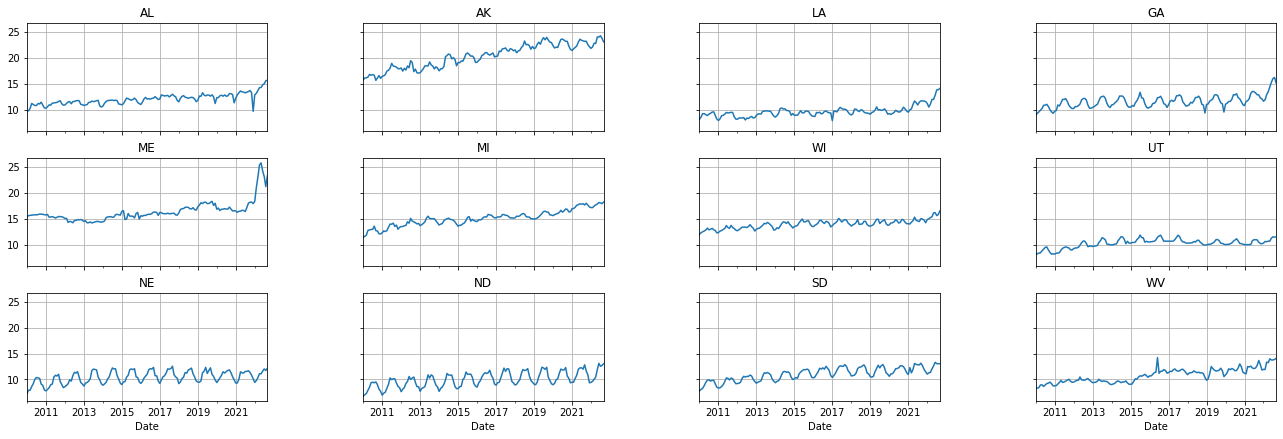

In [ ]:
states = ["AL", "AK", "LA", "GA", "ME", "MI", "WI", "UT", 
          "NE", "ND", "SD", "WV"]
ncols = 4
nrows = int(np.ceil(len(states)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True,
                        sharex=True, figsize=(20,20))
fig.tight_layout(pad=8.0)
for i, state in enumerate(states):
  x = tsdf[state]
  row = int(np.floor(i/ncols))
  col = int(i % ncols)
  ax = axs[row, col]
  x.plot(use_index=True, y="Cents/kWh", ax=ax, 
         title=state, figsize=[20,6], grid=True, sharey=True)

## Comments on state plots
I see a difference in both the levels but also in the patterns.  
Some states have 2 humps a year, presumably for the peak cold and peak heat.  
For some others if that pattern is present at all it is muted.

Let's try clustering and see what we get.

## Convert dataframe to time series dataset
Similar to pytorch or other frameworks, tslearn 
wants the data in a particular format.
But happiliy they provide a tool for converting other formats to the one they use.

I only discovered that I need the transpose of the df
after I looked at the resulting shape.  
The first dimension should be 51 

In [ ]:
from tslearn import utils
tsds = tslearn.utils.to_time_series_dataset(tsdf.T)
tsds.shape

(51, 153, 1)

## Calculate the clusters.
I tried with number of clusters between 3 and 6. 
Using 3 was ok, but I liked the results with 4 better,   
there was a split in the lower cluster from 3
that I thouhght told a better story.

The "metric" parameter is essentially how Kmeans will compare 2 items.  There is another metric, "dtw" or dynamic time warping.  Sounded exciting but I did not want any warping in the comparisons so I stuck with "euclidean"

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
km = {}
nrange = list(range(2, 8))
for n in nrange:
  km[n] = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=150,
                      random_state=0, verbose=False).fit(tsds)
  print(f" n {n}  intertia {km[n].inertia_}")

 n 2  intertia 1006.3067937165777
 n 3  intertia 360.48550451117507
 n 4  intertia 234.7691784650426
 n 5  intertia 169.038489545596
 n 6  intertia 142.46368245409278
 n 7  intertia 133.0554906753813


## Inertia vs Number of Clusters
Below I plot the inertia for each trial on the Y axis and the nuumber of clusters on the X axis.

Inertia is a measure of tighness of the clusters so naturally goes down as we add more clusters.  

The usual advice is to find the "elbow" of the plot.  For me that looks like either 3 or 4, I went with 4.

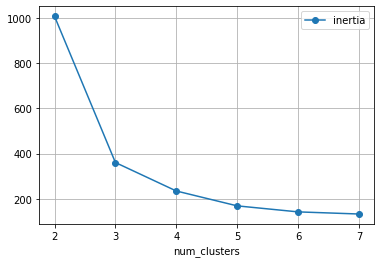

In [ ]:
idf = pd.DataFrame(nrange, [km[n].inertia_ for n in nrange])
idf.reset_index(inplace=True, drop=False)
idf.columns = ["inertia", "num_clusters"]
idf.plot(x="num_clusters", y="inertia", marker="o",  grid=True)

## Plot the clusters
Below I plot the cluster centers for each cluster in black as well as all the states in the cluster in colors.  

There is also a list of the states in the legend.

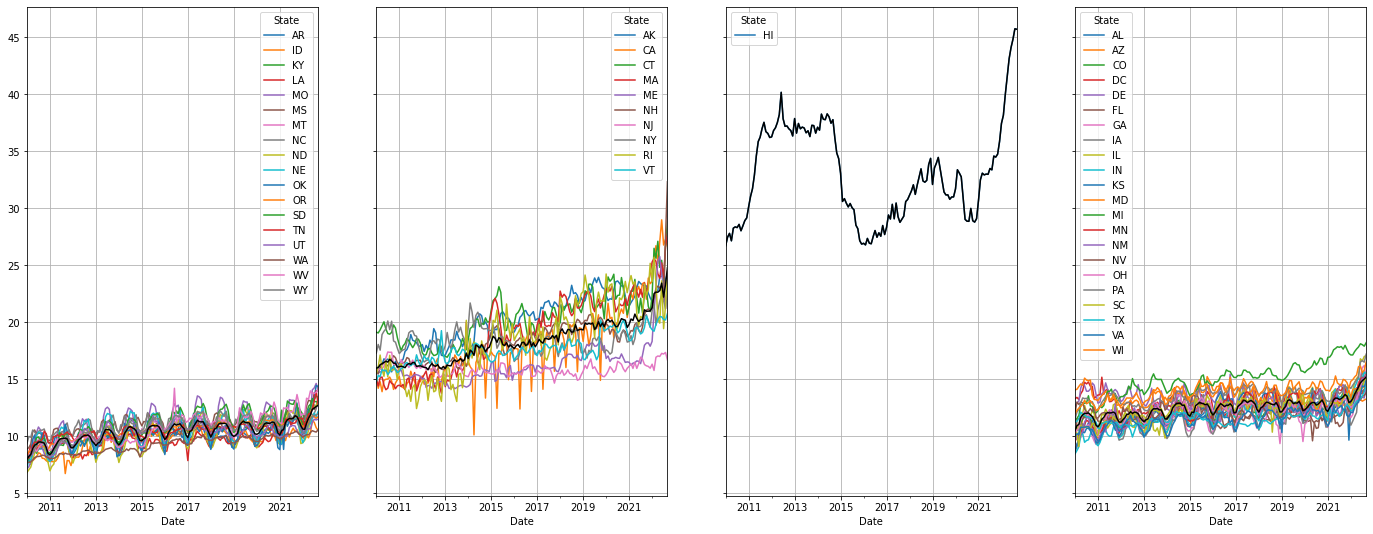

In [ ]:
kmean = km[4]
states = tsdf.columns
centers = np.squeeze(kmean.cluster_centers_)
xdf = pd.DataFrame(centers).T
xdf.index = tsdf.index
fig, axs = plt.subplots(nrows=1, ncols=xdf.shape[1], figsize=[24,9],
                        sharex=True, sharey=True)
for i in range(xdf.shape[1]):
  labs = np.where(kmean.labels_ == i)
  cluster_states = states[list(labs[0])]
  tsdf[cluster_states].plot(ax=axs[i])
  xdf[i].plot(color="black",  ax=axs[i], grid=True)

## Reaction and analysis
I like the clusters, but I am not sure this is so much more informative than clustering on the average level of the series.

I found it interesting that cluster 1 is New England plus Alaska and California.  The prices could be high in some of these due to taxes or some kind of regulations.

I might have hoped that the clustering could have partitioned based on whether the series had the typical 2 humps per year pattern.  Maybe with more clusters we could have done that.

As mentioned above, there are other clustering algorithms available in tslearn, in particular "dtw" or dynamic time warping. I did try this one and did not like the results at much.  Anyway, I did not want to warp the humps, e.g. if one series has humps in different places I would like to see that difference, at least here.

Just for fun, below I plot the clusters where the number of clusters is 7.  It looks like some of the existing clusters were split ... and NY was put in a cluster alone like HI.

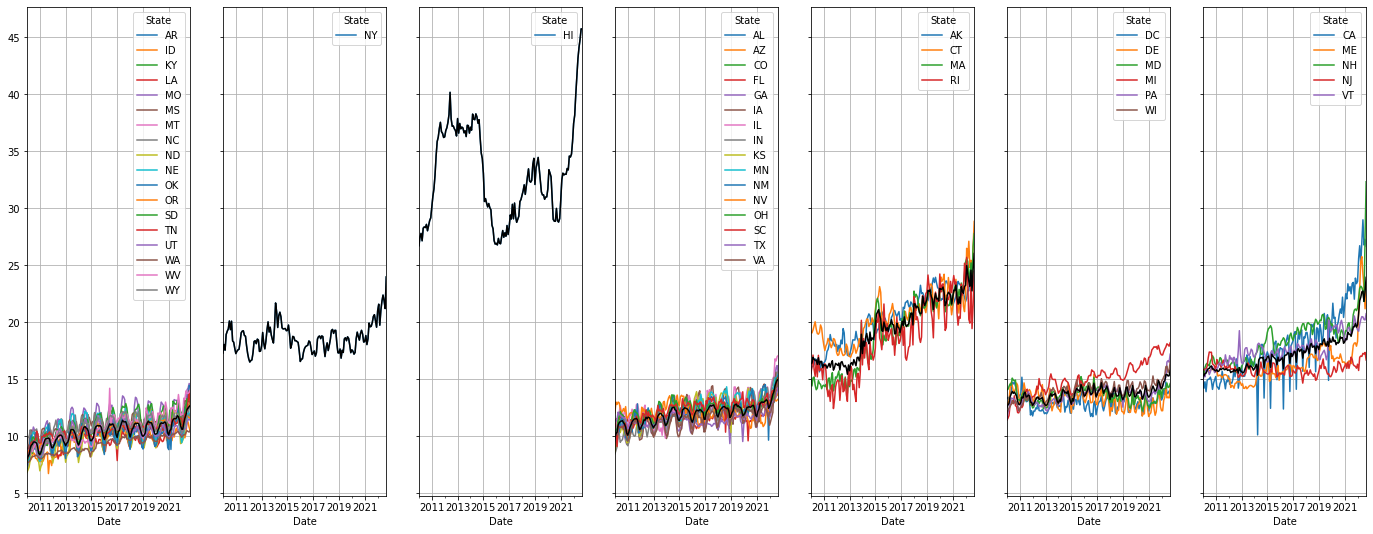

In [ ]:
kmean = km[7]
states = tsdf.columns
centers = np.squeeze(kmean.cluster_centers_)
xdf = pd.DataFrame(centers).T
xdf.index = tsdf.index
fig, axs = plt.subplots(nrows=1, ncols=xdf.shape[1], figsize=[24,9],
                        sharex=True, sharey=True)
for i in range(xdf.shape[1]):
  labs = np.where(kmean.labels_ == i)
  cluster_states = states[list(labs[0])]
  tsdf[cluster_states].plot(ax=axs[i])
  xdf[i].plot(color="black",  ax=axs[i], grid=True)